In [232]:
import pandas as pd
import numpy as np
from datetime import timedelta
# from missingpy import MissForest #impute missing value
from sklearn.preprocessing import MinMaxScaler #standardized data
import random
import matplotlib.pyplot as plt

#deep learning package
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import ParameterGrid

In [2]:
fitbit_survey2 = pd.read_csv('fitbit_survey2.csv')
select_survey = pd.read_csv('select_survey.csv')

fitbit_survey2.drop(columns = ['Unnamed: 0'], inplace = True)
select_survey.drop(columns = ['Unnamed: 0'], inplace = True)

### Padding

In [3]:
mental_health1 =  select_survey['mental_health_1'].values
mental_health2 =  select_survey['mental_health_2'].values

ids = fitbit_survey2['Id'].unique()
max_short_day = 0
max_long_day = 0
for id in ids:
    individual_data_short = fitbit_survey2[(fitbit_survey2['Id'] == id) & (fitbit_survey2['survey_date'] < 2)]
    individual_data_long = fitbit_survey2[(fitbit_survey2['Id'] == id) & (fitbit_survey2['survey_date'] < 4)]
    if len(individual_data_short) > max_short_day:
        max_short_day = len(individual_data_short)

    if len(individual_data_long) > max_long_day:
        max_long_day = len(individual_data_long)

# List to store padded matrices for each ID
padded_matrices = []

for id_val in ids:
    # Filter data for the current `id_val` and specified condition
    id_data = fitbit_survey2[(fitbit_survey2['Id'] == id_val) & (fitbit_survey2['survey_date'] < 2)]

    max_rows = max_short_day
    col = id_data.shape[1]
    
    # Convert to matrix (numpy array) without 'Id' and 'survey_date' columns
    id_matrix = id_data.drop(columns=['Id', 'survey_date']).values
    
    # Pad each matrix to the target shape (max_rows, max_cols)
    padded_id_matrix = np.pad(id_matrix, ((0, max_rows - id_matrix.shape[0]), (0, col - id_matrix.shape[1])), mode='constant', constant_values=0) 
    #pad the dataset with the same length with 0 and the padding value will be ignored by masking
    
    # Append the padded matrix to the list
    padded_matrices.append(padded_id_matrix) #add 2D matrix to 3D

# Stack all matrices into a single 3D array (number of IDs, max_rows, max_cols)
final_padded_matrix = np.stack(padded_matrices, axis=0) 


# List to store padded matrices for each ID
padded_matrices2 = []

for id_val in ids:
    # Filter data for the current `id_val` and specified condition
    id_data = fitbit_survey2[(fitbit_survey2['Id'] == id_val) & (fitbit_survey2['survey_date'] < 4)]

    max_rows = max_long_day
    col = id_data.shape[1]
    
    # Convert to matrix (numpy array) without 'Id' and 'survey_date' columns
    id_matrix = id_data.drop(columns=['Id', 'survey_date']).values
    
    # Pad each matrix to the target shape (max_rows, max_cols)
    padded_id_matrix = np.pad(id_matrix, ((0, max_rows - id_matrix.shape[0]), (0, col - id_matrix.shape[1])), mode='constant', constant_values=0) 
    #pad the dataset with the same length with 0 and the padding value will be ignored by masking
    
    # Append the padded matrix to the list
    padded_matrices2.append(padded_id_matrix) #add 2D matrix to 3D

# Stack all matrices into a single 3D array (number of IDs, max_rows, max_cols)
final_padded_matrix2 = np.stack(padded_matrices2, axis=0) 

### Prepare dataset

In [182]:
X_short_data = final_padded_matrix.copy()
X_long_data = final_padded_matrix2.copy()
y_short_data = mental_health1.copy()
y_long_data = mental_health2.copy()

In [183]:
#standardize the data
scaler = MinMaxScaler()

X_reshpaed = X_short_data.reshape(-1, X_short_data.shape[2])
X_standardized = scaler.fit_transform(X_reshpaed)
X_short_standardized = X_standardized.reshape(X_short_data.shape)

X_reshpaed2 = X_long_data.reshape(-1, X_long_data.shape[2])
X_standardized2 = scaler.fit_transform(X_reshpaed2)
X_short_standardized2 = X_standardized2.reshape(X_long_data.shape) #

In [184]:
def train_test_split(dataX, datay, shuffle = True, train_percentage = 0.7):
    if shuffle:
        random_indices = np.arange(len(dataX))
        np.random.shuffle(random_indices)
        dataX = dataX[random_indices]
        datay = datay[random_indices]
    
    # Compute split indices
    train_end = int(len(dataX) * train_percentage)

    # Split the data
    train_X, train_y = dataX[:train_end], datay[:train_end]
    test_X, test_y = dataX[train_end:], datay[train_end:]
    
    return train_X, train_y, test_X, test_y 

In [185]:
#split data to training and validating
train_X_data, train_y_data, test_X_data, test_y_data = train_test_split(X_short_standardized, y_short_data) 
train_y_data = train_y_data.reshape(-1, 1)
test_y_data = test_y_data.reshape(-1, 1)

In [191]:
#standardize y in order to decrease the value of loss function
train_y_mean = train_y_data.mean()
train_y_std = train_y_data.std()

train_y = (train_y_data - train_y_mean) / train_y_std
test_y = (test_y_data - train_y_mean) / train_y_std

train_X_new = torch.tensor(train_X_data, dtype=torch.float32) # torch.Size([58, 109, 39])
train_y_new = torch.tensor(train_y, dtype=torch.float32) # torch.Size([58, 1]) 
test_X_new = torch.tensor(test_X_data, dtype=torch.float32)  # torch.Size([14, 109, 39])
test_y_new = torch.tensor(test_y, dtype=torch.float32) # torch.Size([14, 1])

## CNN-RNN Model (Baseline)

In [275]:
class CNN_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNN_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1D Convolution
        self.conv = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=2)
        
        # RNN
        self.rnn = nn.RNN(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Input shape: (batch_size, seq_len, features)
        # Permute to (batch_size, features, seq_len) for Conv1d
        x = x.permute(0, 2, 1)
        x = self.conv(x)  # Apply convolution
        x = x.permute(0, 2, 1)  # Permute back to (batch_size, seq_len, features)

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # RNN forward pass
        out, _ = self.rnn(x, h0)

        # Extract the output at the last time step
        last_outputs = out[:, -1, :]  # (batch_size, hidden_size)

        # Fully connected layer
        out = self.fc(last_outputs)
        return out


# Modified training function to return training and testing losses
def train_and_evaluate(model, train_X, train_y, test_X, test_y, criterion, optimizer, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass on training data
        outputs = model(train_X)
        train_loss = criterion(outputs, train_y)

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()

        # Store the training loss
        train_losses.append(train_loss.item())

        # Evaluate on the test data
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_X)
            test_loss = criterion(test_outputs, test_y).item()
            test_losses.append(test_loss)

        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss.item():.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

### Tune CNN-RNN Model (Baseline)

In [264]:
#hyperparameters tuning
input_size = train_X_new.shape[2]  # Feature size
output_size = 1
# Define the hyperparameter space
hyperparameter_space = {
    'hidden_size': [16, 32, 64],
    'num_layers': [1, 2, 3],
    'learning_rate': [0.01, 0.001, 0.0001],
}

param_grid = ParameterGrid(hyperparameter_space)

# Track the best hyperparameters
best_params = None
best_loss = float('inf')

for params in param_grid:
    print(f"Testing hyperparameters: {params}")

    # Extract hyperparameters
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']

    # Initialize the model, criterion, and optimizer
    model = CNN_RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train and evaluate the model
    test_loss = train_and_evaluate(
        model,
        train_X_new,
        train_y_new,
        test_X_new,
        test_y_new,
        criterion,
        optimizer,
        num_epochs=50
    )
    mean_loss = np.mean(test_loss)
    print(f"Test Loss: {mean_loss:.4f}")

    # Check if this is the best model so far
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_params = params

# Print the best hyperparameters and loss
print(f"Best Hyperparameters: {best_params}")
print(f"Best Loss: {best_loss:.4f}")

Testing hyperparameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_layers': 1}
Epoch [10/50], Training Loss: 0.9952, Test Loss: 1.1482
Epoch [20/50], Training Loss: 0.9930, Test Loss: 1.1445
Epoch [30/50], Training Loss: 0.9930, Test Loss: 1.1404
Epoch [40/50], Training Loss: 0.9929, Test Loss: 1.1433
Epoch [50/50], Training Loss: 0.9929, Test Loss: 1.1421
Test Loss: 1.0687
Testing hyperparameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_layers': 2}
Epoch [10/50], Training Loss: 0.9941, Test Loss: 1.1372
Epoch [20/50], Training Loss: 0.9933, Test Loss: 1.1434
Epoch [30/50], Training Loss: 0.9931, Test Loss: 1.1455
Epoch [40/50], Training Loss: 0.9908, Test Loss: 1.1431
Epoch [50/50], Training Loss: 0.9933, Test Loss: 1.1406
Test Loss: 1.0694
Testing hyperparameters: {'hidden_size': 16, 'learning_rate': 0.01, 'num_layers': 3}
Epoch [10/50], Training Loss: 0.9987, Test Loss: 1.1421
Epoch [20/50], Training Loss: 0.9943, Test Loss: 1.1424
Epoch [30/50], Training Loss: 1.0934,

In [278]:
input_size = train_X_new.shape[2]  # Feature size
output_size = 1  # Continuous output variable
hidden_size = 64 # Number of hidden units
num_layers = 2 # Number of RNN layers
learning_rate = 0.001
num_epochs = 500

# Initialize the model, criterion, and optimizer
model = CNN_RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
criterion = nn.MSELoss()  # Mean Squared Error for continuous variables
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = train_and_evaluate(
    model,
    train_X_new,
    train_y_new,
    test_X_new,
    test_y_new,
    criterion,
    optimizer,
    num_epochs=num_epochs
)

# Plot the training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs (CNN-RNN)')
plt.legend()
plt.grid(True)
plt.show()

Epoch [10/500], Training Loss: 0.9928, Test Loss: 1.1389
Epoch [20/500], Training Loss: 0.9928, Test Loss: 1.1411
Epoch [30/500], Training Loss: 0.9930, Test Loss: 1.1438
Epoch [40/500], Training Loss: 0.9929, Test Loss: 1.1433
Epoch [50/500], Training Loss: 0.9928, Test Loss: 1.1422
Epoch [60/500], Training Loss: 0.9928, Test Loss: 1.1420
Epoch [70/500], Training Loss: 0.9926, Test Loss: 1.1420
Epoch [80/500], Training Loss: 0.9871, Test Loss: 1.1432
Epoch [90/500], Training Loss: 0.9087, Test Loss: 1.2529
Epoch [100/500], Training Loss: 0.7729, Test Loss: 0.8859
Epoch [110/500], Training Loss: 0.5725, Test Loss: 1.2784
Epoch [120/500], Training Loss: 0.4405, Test Loss: 1.2641
Epoch [130/500], Training Loss: 0.3302, Test Loss: 1.4313
Epoch [140/500], Training Loss: 0.5355, Test Loss: 1.1198
Epoch [150/500], Training Loss: 0.3779, Test Loss: 1.6425
Epoch [160/500], Training Loss: 0.2247, Test Loss: 1.5537
Epoch [170/500], Training Loss: 0.1714, Test Loss: 1.6291
Epoch [180/500], Traini

KeyboardInterrupt: 

### CNN-LSTM model

In [196]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers, output_size):
        super(CNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # LSTM layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Rearrange dimensions for Conv1D
        x = x.permute(0, 2, 1)  # (batch_size, input_size, seq_len)
        
        # Pass through Conv1D
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.pool(x)  # (batch_size, hidden_size, reduced_seq_len)
        
        # Rearrange dimensions for LSTM
        x = x.permute(0, 2, 1)  # (batch_size, reduced_seq_len, hidden_size)

        # Pass through LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))  # (batch_size, reduced_seq_len, hidden_size)

        # Take the last time step
        out = out[:, -1, :]  # (batch_size, hidden_size)

        # Fully connected layer
        out = self.fc(out)  # (batch_size, output_size)

        return out

In [280]:
def train_and_evaluate(params, train_X, train_y, test_X, test_y, num_epochs):
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    
    # Model instantiation
    model = CNN_LSTM(
        input_size=train_X.shape[2],
        seq_len=train_X.shape[1],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=1
    )
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize lists to track losses
    train_losses = []
    test_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for i in range(0, len(train_X), batch_size):
            batch_X = train_X[i:i + batch_size]
            batch_y = train_y[i:i + batch_size]

            # Forward pass
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_train_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Average training loss for the epoch
        avg_train_loss = total_train_loss / (len(train_X) // batch_size)
        train_losses.append(avg_train_loss)

        # Evaluation loop
        model.eval()
        with torch.no_grad():
            total_test_loss = 0
            for i in range(0, len(test_X), batch_size):
                batch_X = test_X[i:i + batch_size]
                batch_y = test_y[i:i + batch_size]

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                total_test_loss += loss.item()

        # Average testing loss for the epoch
        avg_test_loss = total_test_loss / (len(test_X) // batch_size)
        test_losses.append(avg_test_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses, avg_test_loss


In [279]:
# Function to train and evaluate the model
hyperparameter_space = {
    'hidden_size': [4, 8, 16, 32, 64],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [6, 8, 16],
}

# Store results
best_params = None
best_loss = float('inf')
all_train_losses = []
all_test_losses = []
num_epochs = 50
# Hyperparameter tuning
for hidden_size, num_layers, learning_rate, batch_size in hyperparameter_space:
    params = {
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
    }
    print(f"Testing combination: {params}")
    train_losses, test_losses, avg_loss = train_and_evaluate(params, train_X_new, train_y_new, test_X_new, test_y_new, num_epochs)
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)

    print(f"Avg Test Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"Best Hyperparameters: {best_params}")
print(f"Best Loss: {best_loss:.4f}")

ValueError: too many values to unpack (expected 4)

Epoch [1/500] - Train Loss: 1.1006, Test Loss: 1.4798
Epoch [2/500] - Train Loss: 1.0949, Test Loss: 1.4823
Epoch [3/500] - Train Loss: 1.0933, Test Loss: 1.4838
Epoch [4/500] - Train Loss: 1.0922, Test Loss: 1.4848
Epoch [5/500] - Train Loss: 1.0910, Test Loss: 1.4853
Epoch [6/500] - Train Loss: 1.0897, Test Loss: 1.4855
Epoch [7/500] - Train Loss: 1.0881, Test Loss: 1.4855
Epoch [8/500] - Train Loss: 1.0866, Test Loss: 1.4852
Epoch [9/500] - Train Loss: 1.0852, Test Loss: 1.4847
Epoch [10/500] - Train Loss: 1.0840, Test Loss: 1.4841
Epoch [11/500] - Train Loss: 1.0831, Test Loss: 1.4835
Epoch [12/500] - Train Loss: 1.0821, Test Loss: 1.4830
Epoch [13/500] - Train Loss: 1.0810, Test Loss: 1.4827
Epoch [14/500] - Train Loss: 1.0797, Test Loss: 1.4828
Epoch [15/500] - Train Loss: 1.0778, Test Loss: 1.4830
Epoch [16/500] - Train Loss: 1.0754, Test Loss: 1.4837
Epoch [17/500] - Train Loss: 1.0738, Test Loss: 1.4845
Epoch [18/500] - Train Loss: 1.0692, Test Loss: 1.4858
Epoch [19/500] - Tr

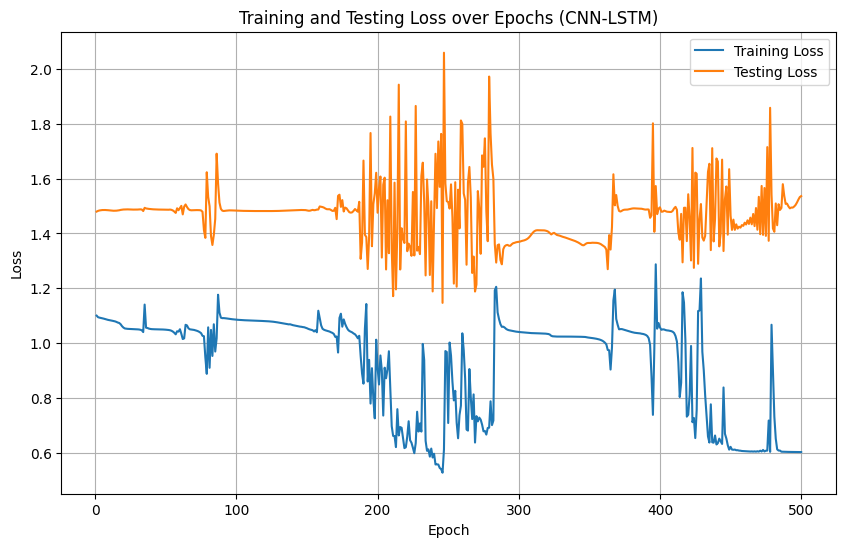

In [282]:
hidden_size = 32
num_layers = 2
learning_rate = 0.001
batch_size = 6
num_epochs = 500
params = {
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
    }

train_losses, test_losses, avg_loss = train_and_evaluate(params, train_X_new, train_y_new, test_X_new, test_y_new, num_epochs)

# Plotting the training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs (CNN-LSTM)')
plt.legend()
plt.grid(True)
plt.show()